In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../')
from dfHelper import*
import warnings
warnings.filterwarnings('ignore')

In [3]:
# we train a classsifier for each sensor

def data (sensor, min_length=800):
    """
    prepare the data for each sensor classifier
    """
    subjects = [1,2,3]
    runs = [1,2,3,4,5]
    data = []
    targets = []
    lengths = []
    for subject in subjects:
        for run in runs:
            d = load_data_adl(subject, run, '../OpportunityUCIDataset')
            walk, lie =  get_locomotion_data(d, [2]), get_locomotion_data(d, [5])
            walk, lie = get_sensor_data(walk, sensor), get_sensor_data(lie, sensor)
            walk, lie = walk[walk.columns[:-8]], lie[lie.columns[:-8]]

            lie = lie.dropna()
            walk = walk.dropna()
            if len(lie)<min_length or len(walk)<min_length:
                continue

            lengths.append(len(lie))
            lengths.append(len(walk))

            for c in lie.columns:
                data.append(lie[c].values)
                targets.append(0)
            for c in walk.columns:
                data.append(walk[c].values)
                targets.append(1)
    #cut legth of data to the same length
    min_length = min(lengths)
    for i in range(len(data)):
        data[i] = data[i][:min_length]

    from sklearn.utils import shuffle
    data, targets = shuffle(data, targets)

    return data, targets

In [4]:
dsid = 'FaceDetection' 
X, y, splits = get_UCR_data('ECGFiveDays', return_split=False)

n data 154
target 0:  77
target 1:  77


epoch,train_loss,valid_loss,accuracy,time
0,0.644480,0.556764,0.935484,00:14
1,0.466218,0.216549,0.935484,00:09
2,0.371397,0.162467,0.903226,00:13
3,0.297383,0.180136,0.935484,00:10


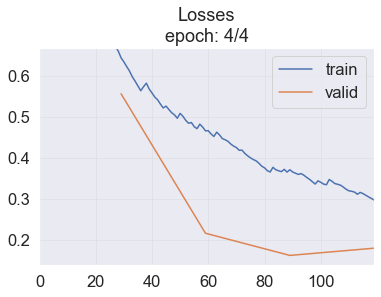

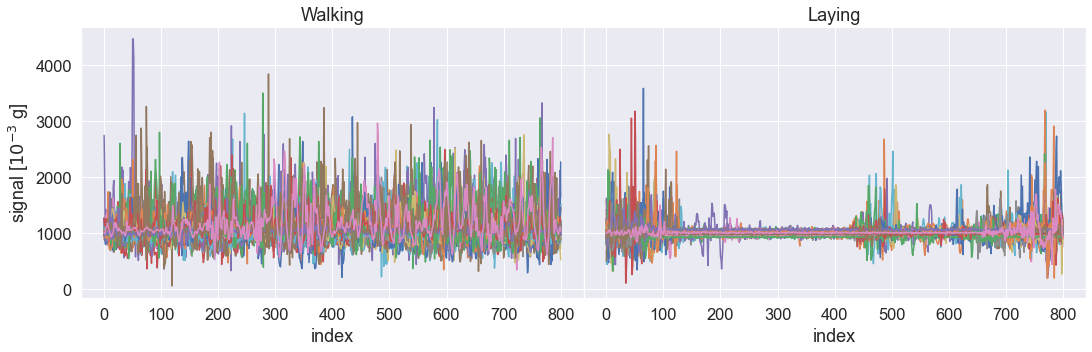

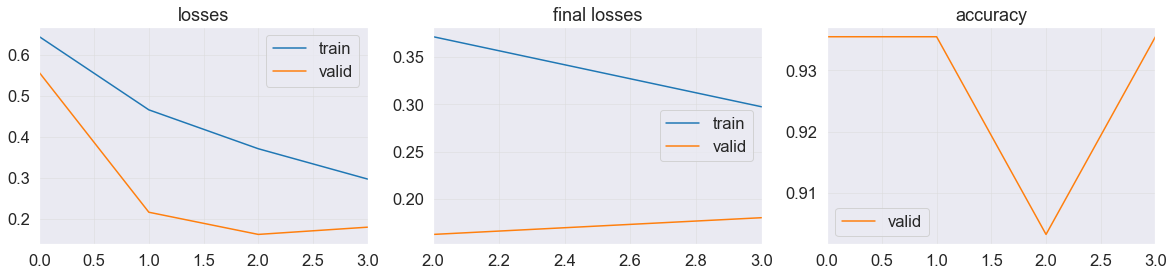

n data 140
target 0:  70
target 1:  70


epoch,train_loss,valid_loss,accuracy,time
0,0.437126,0.451735,1.000000,00:15
1,0.304552,0.053219,1.000000,00:08
2,0.247949,0.041149,1.000000,00:11
3,0.182731,0.037629,1.000000,00:10


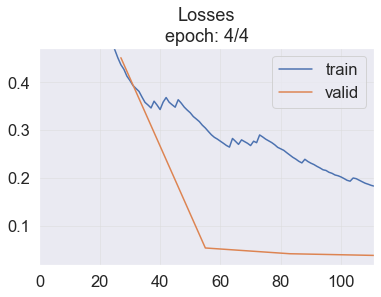

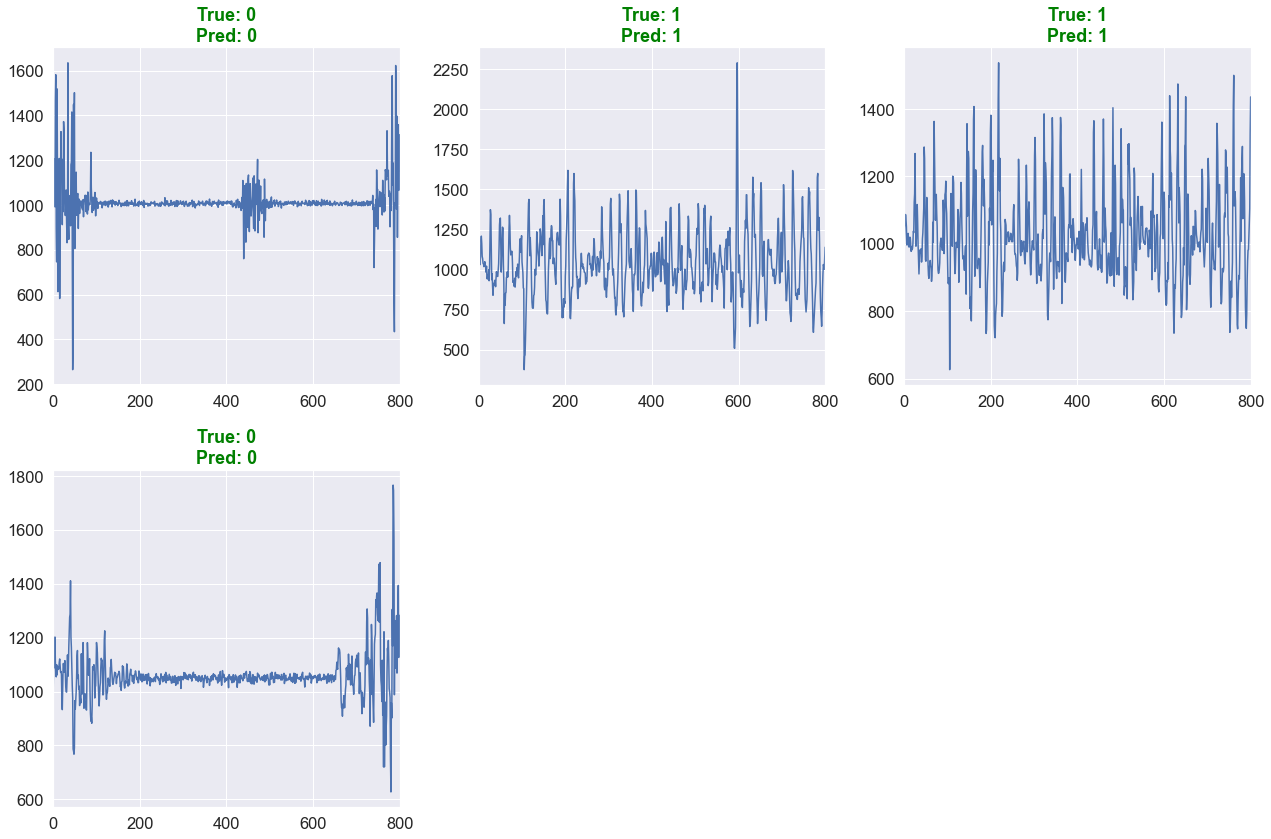

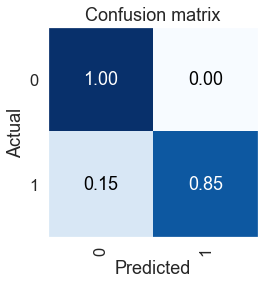

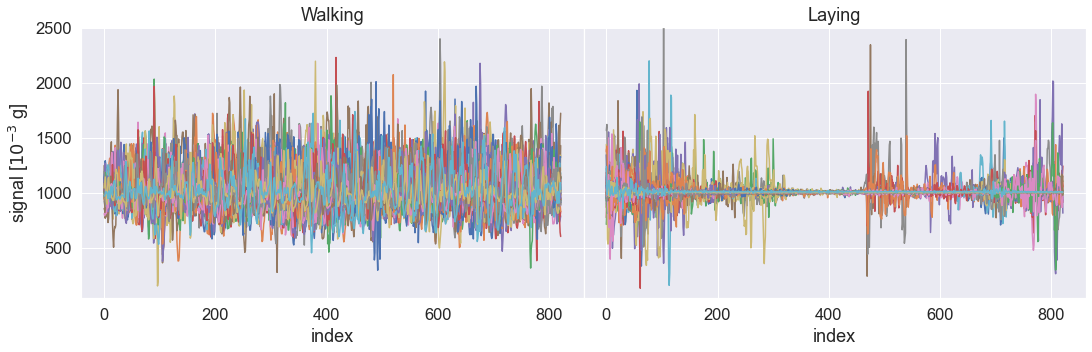

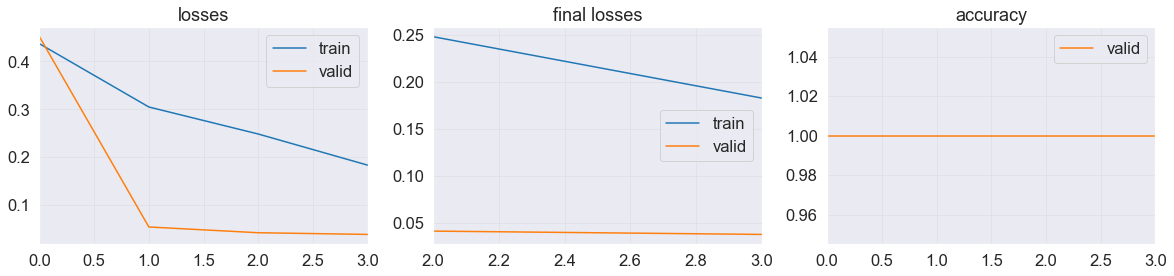

n data 140
target 0:  70
target 1:  70


epoch,train_loss,valid_loss,accuracy,time
0,0.418253,0.285401,1.000000,00:08
1,0.243493,0.082993,1.000000,00:08
2,0.192047,0.036057,1.000000,00:12
3,0.163938,0.035770,1.000000,00:13


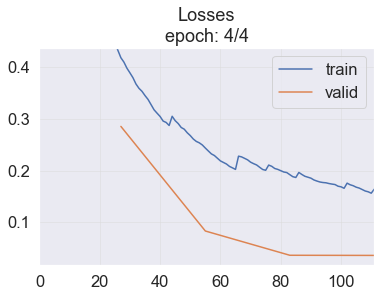

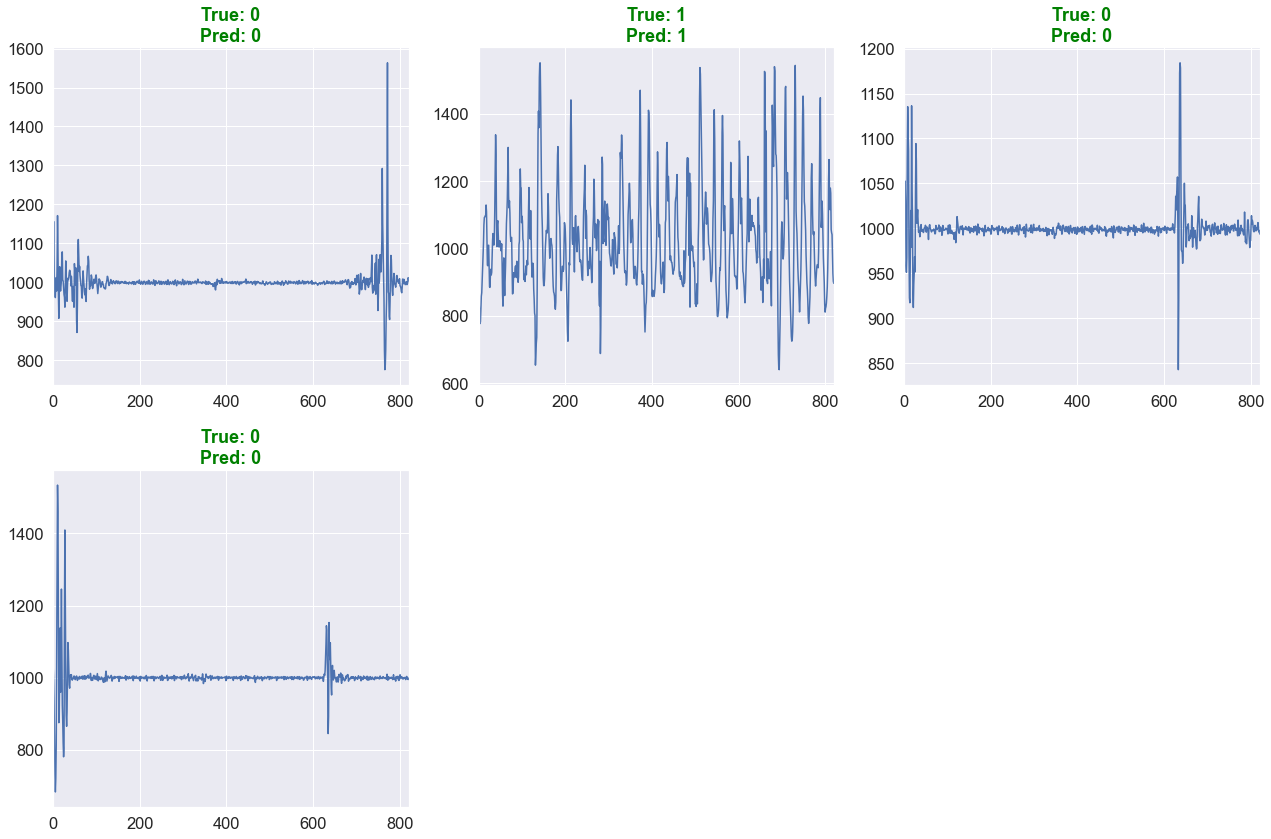

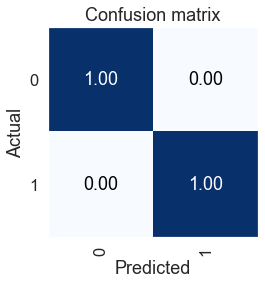

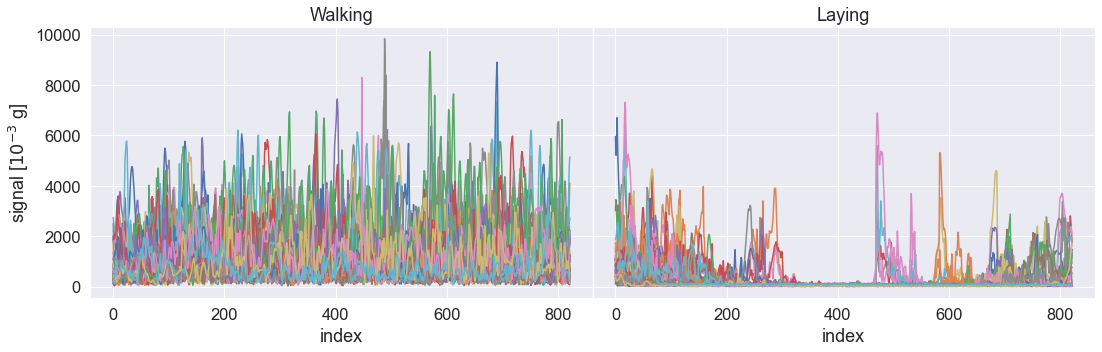

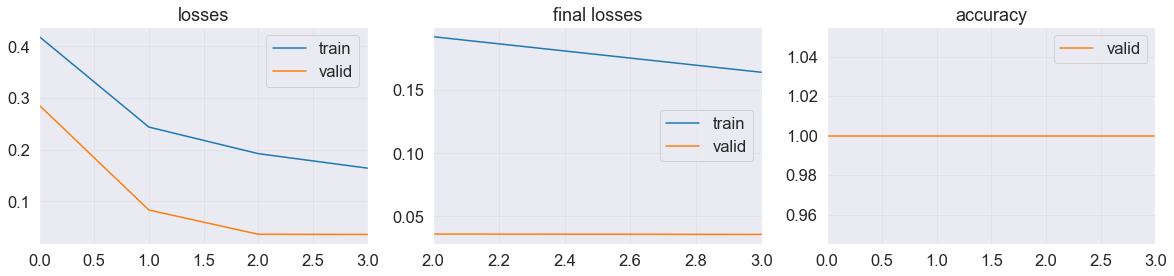

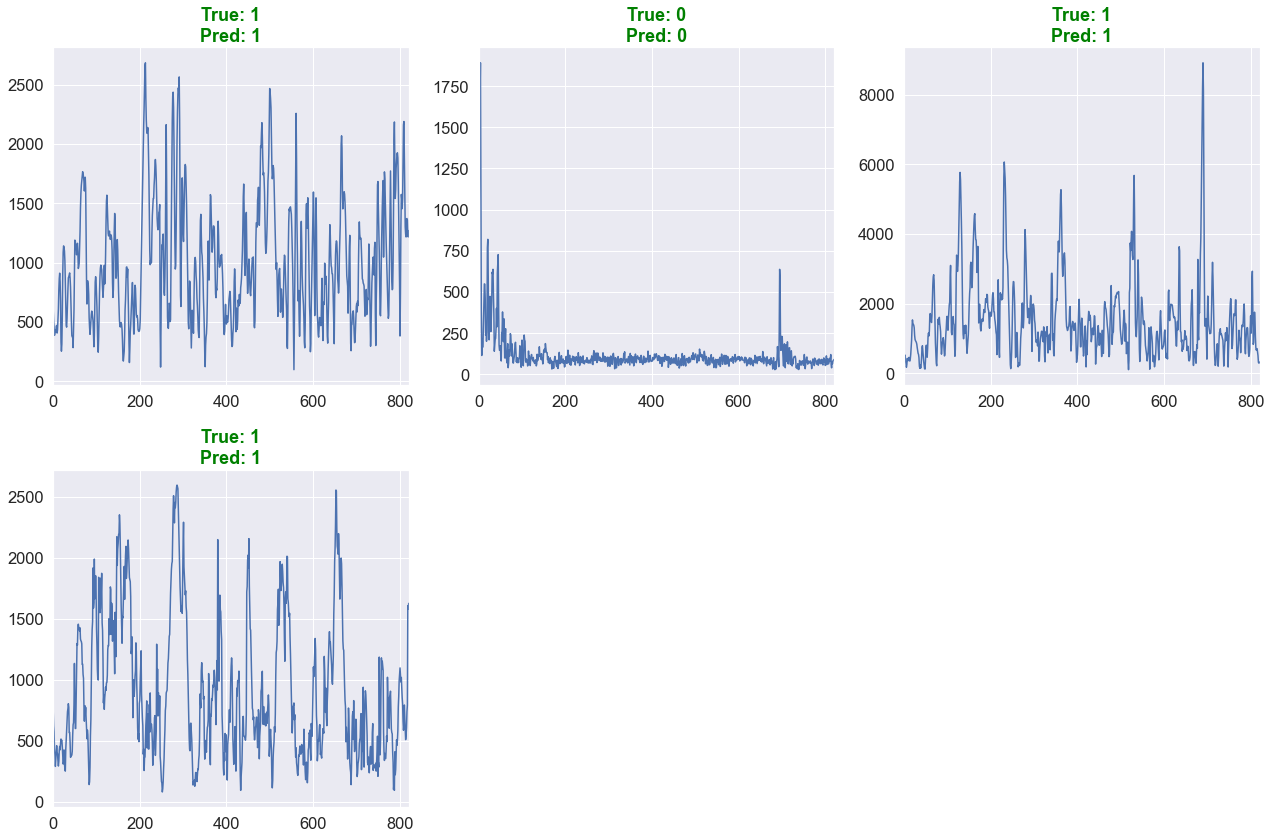

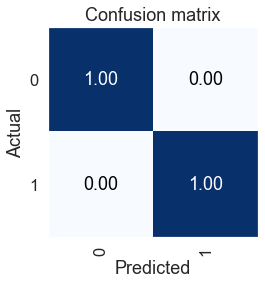

In [7]:
sensors = ["triaxial_acc", "IMU_acc", "IMU_gyro"]
epochs = 4
lr = 1e-4

from tsai.all import *

def train_model (X, y, filename, epochs, lr, frac=0.8):

    X = np.array(X)
    X = X.reshape(X.shape[0], 1, X.shape[1])
    y = np.array(y)

    splits = np.arange(len(X), dtype=int)
    np.random.shuffle(splits)
    splits = [splits[:int(len(splits)*frac)], splits[int(len(splits)*frac):]]
    splits = [[int(i) for i in splits[k]] for k in range(2)]

    if not os.path.isdir('models'): 
        os.mkdir('models')

    bs = 4
    tfms  = [None, [Categorize()]]
    dsets = TSDatasets(X, y, tfms=tfms,  inplace=True, splits=splits)
    dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=bs)
    model = InceptionTime(dls.vars, dls.c)
    clf = Learner(dls, model, metrics=accuracy, cbs=ShowGraph())

    clf.fit_one_cycle(epochs, lr)
    clf.export('models/'+filename+".pkl")
    clf.show_results()
    interp = ClassificationInterpretation.from_learner(clf)
    interp.plot_confusion_matrix(normalize=True)


for s in sensors:
    # data preparation
    
    train_data, train_targets = data(s)
    print ('n data {}'.format(len(train_targets)))
    print ('target 0: ', sum(np.array(train_targets)==0))
    print ('target 1: ', sum(np.array(train_targets)==1))

    #plot 
    fig, ax = plt.subplots(1,2, figsize=(18,5))
    sns.set_theme(style='darkgrid', palette='deep', font_scale=1.5)
    for X, y in zip(train_data, train_targets):
        if y == 1:
            sns.lineplot(x=range(len(X)), y=X, label=y, ax=ax[0])
        else:
            sns.lineplot(x=range(len(X)), y=X, label=y, ax=ax[1])
    ax[0].legend().remove()
    ax[1].legend().remove()
    ax[1].set_ylim(ax[0].get_ylim())
    fig.subplots_adjust(hspace=.0, wspace=0.)
    ax[1].set_yticklabels([])
    ax[0].set_title('Walking')
    ax[1].set_title('Laying')
    ax[0].set_xlabel('index')
    ax[1].set_xlabel('index')
    ax[0].set_ylabel(r'signal [$10^{-3}$ g]')


    import os
    if not os.path.exists('figures'):
        os.mkdir('figures')
    fig.savefig('figures/'+s+'_signals_walk_lie.pdf')

    #train classifier
    train_model (train_data, train_targets, str(s), epochs, lr)

In [117]:
def data_centers(sensor, nclusters, metric='euclidean'):

    if sensor == "triaxial_acc": min_length=800
    elif sensor == "IMU_acc": min_length=0
    elif sensor == "IMU_gyro": min_length=0
    
    X, y = list(), list()
     
    subjects = [1,2,3]
    runs = [1,2,3, 4]
    length = []
    for s in subjects:
        for r in runs:
            data_laying = pd.read_csv('clustering_results_{}/subject_{}/run_{}/laying/sensor_type_{}/{}_clusters.csv'\
                                    .format(metric, s, r, sensor, nclusters))
            data_walking = pd.read_csv('clustering_results_{}/subject_{}/run_{}/walking/sensor_type_{}/{}_clusters.csv'\
                                    .format(metric, s, r, sensor, nclusters))
            for i in range(nclusters):
                series = data_laying['center {}'.format(i)]
                if len(series)>min_length:
                    X.append(series.values)
                    y.append(0)
                    length.append(len(series))
                
                series = data_walking['centers {}'.format(i)]
                if len(series)>min_length:
                    X.append(series.values)
                    y.append(1)
                    length.append(len(series))

    #same length
    min_length = min(length)

    for i in range(len(X)):
        X[i] = X[i][:min_length]
    
    from sklearn.utils import shuffle
    X, y = shuffle(X, y)

    #plot 
    fig, ax = plt.subplots(1,2, figsize=(18,5))
    sns.set_theme(style='darkgrid', palette='deep', font_scale=1.5)
    for xx, yy in zip(X, y):
        if yy == 1:
            sns.lineplot(x=range(len(xx)), y=xx, label=yy, ax=ax[0])
        else:
            sns.lineplot(x=range(len(xx)), y=xx, label=yy, ax=ax[1])
    ax[0].legend().remove()
    ax[1].legend().remove()
    ax[1].set_ylim(ax[0].get_ylim())
    fig.subplots_adjust(hspace=.0, wspace=0.)
    ax[1].set_yticklabels([])
    ax[0].set_title('Walking')
    ax[1].set_title('Laying')
    

    return X, y

1 centers, sensor type triaxial_acc

accuracy:  1.0 
confusion matrix:
 [[1. 0.]
 [0. 1.]]


1 centers, sensor type IMU_acc

accuracy:  1.0 
confusion matrix:
 [[1. 0.]
 [0. 1.]]


1 centers, sensor type IMU_gyro

accuracy:  1.0 
confusion matrix:
 [[1. 0.]
 [0. 1.]]


2 centers, sensor type triaxial_acc

accuracy:  1.0 
confusion matrix:
 [[1. 0.]
 [0. 1.]]


2 centers, sensor type IMU_acc

accuracy:  1.0 
confusion matrix:
 [[1. 0.]
 [0. 1.]]


2 centers, sensor type IMU_gyro

accuracy:  1.0 
confusion matrix:
 [[1. 0.]
 [0. 1.]]


3 centers, sensor type triaxial_acc

accuracy:  1.0 
confusion matrix:
 [[1. 0.]
 [0. 1.]]


3 centers, sensor type IMU_acc

accuracy:  1.0 
confusion matrix:
 [[1. 0.]
 [0. 1.]]


3 centers, sensor type IMU_gyro

accuracy:  1.0 
confusion matrix:
 [[1. 0.]
 [0. 1.]]


4 centers, sensor type triaxial_acc

accuracy:  1.0 
confusion matrix:
 [[1. 0.]
 [0. 1.]]


4 centers, sensor type IMU_acc

accuracy:  1.0 
confusion matrix:
 [[1. 0.]
 [0. 1.]]


4 centers, sensor type IMU_gyro

accuracy:  1.0 
confusion matrix:
 [[1. 0.]
 [0. 1.]]


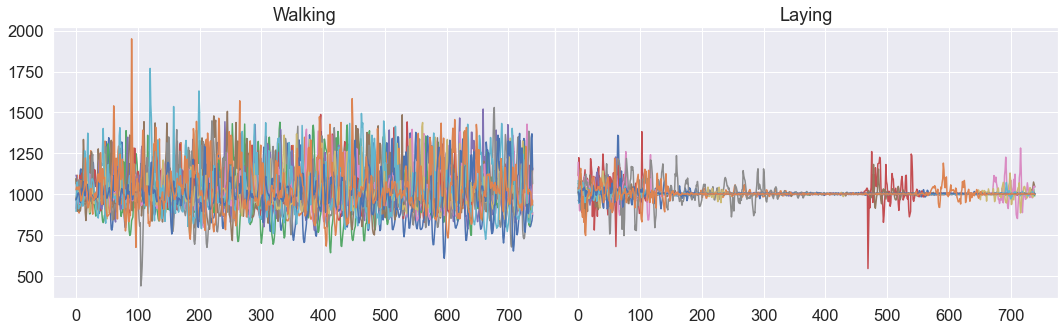

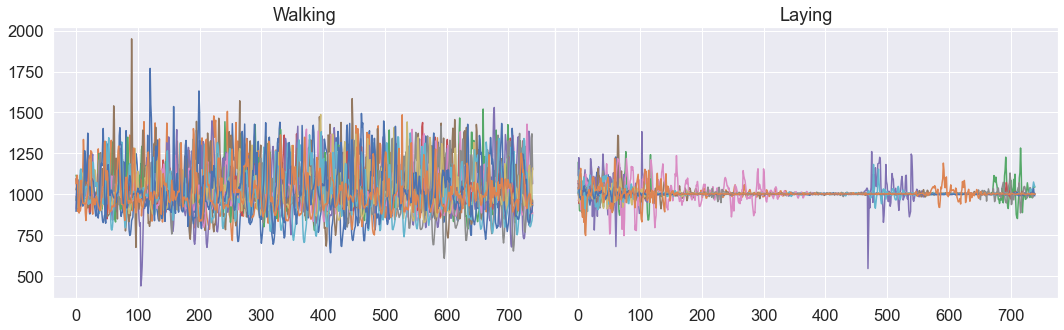

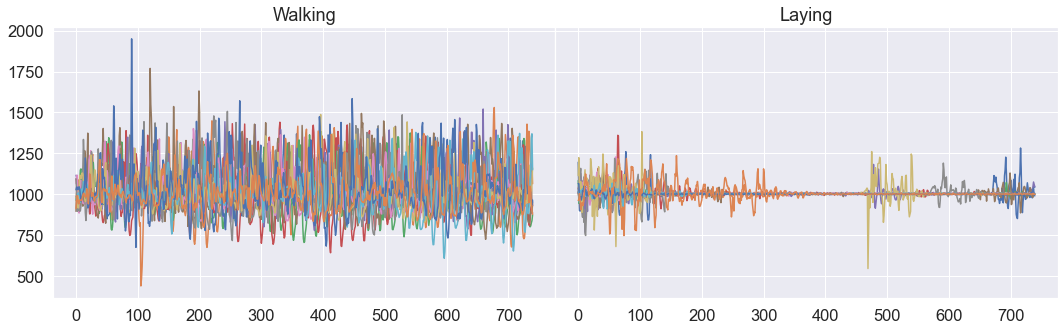

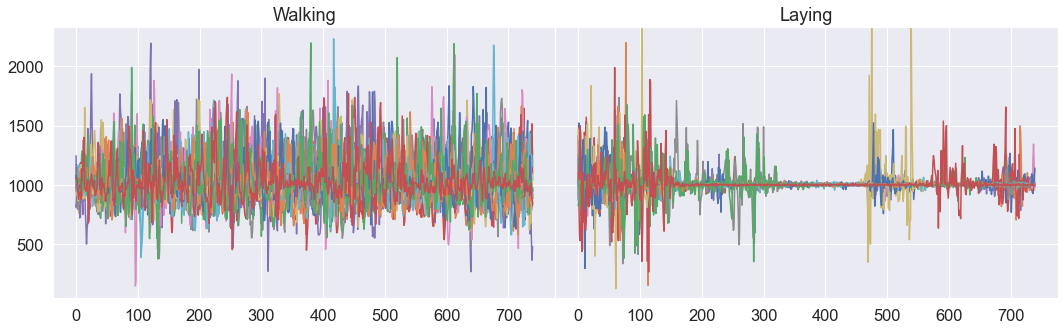

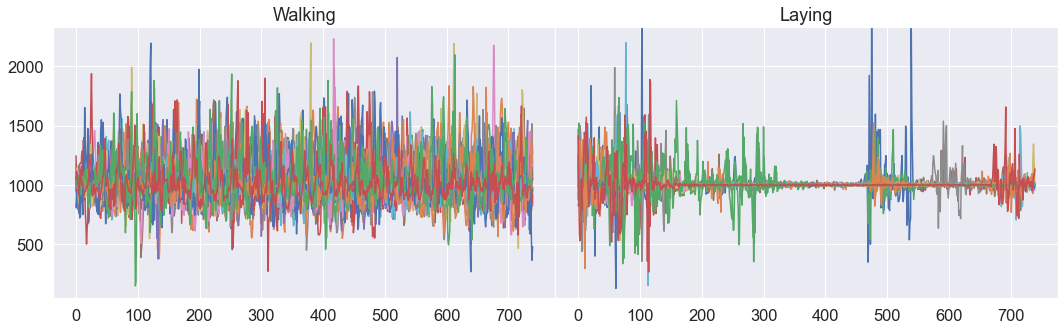

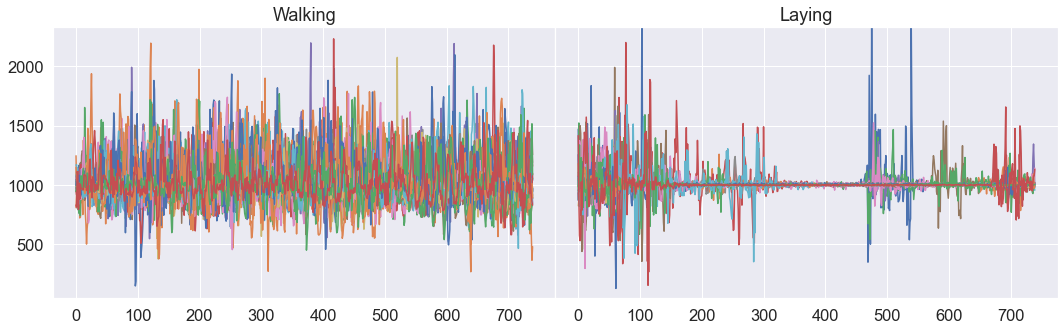

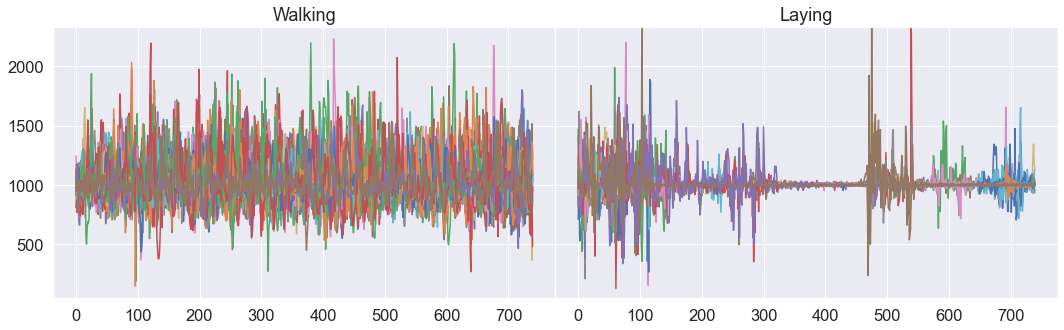

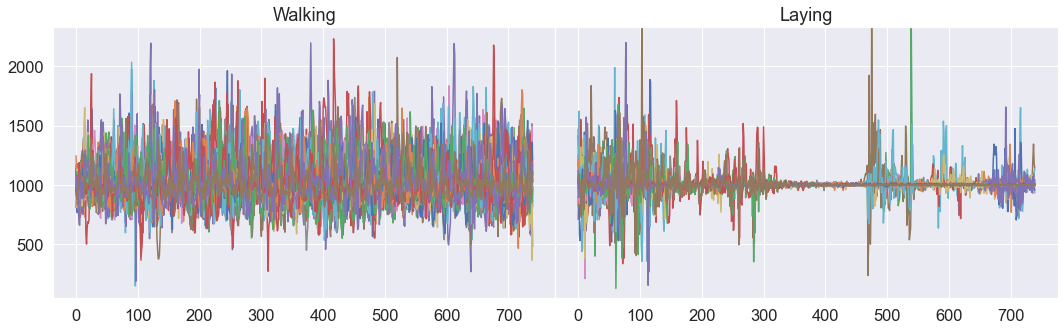

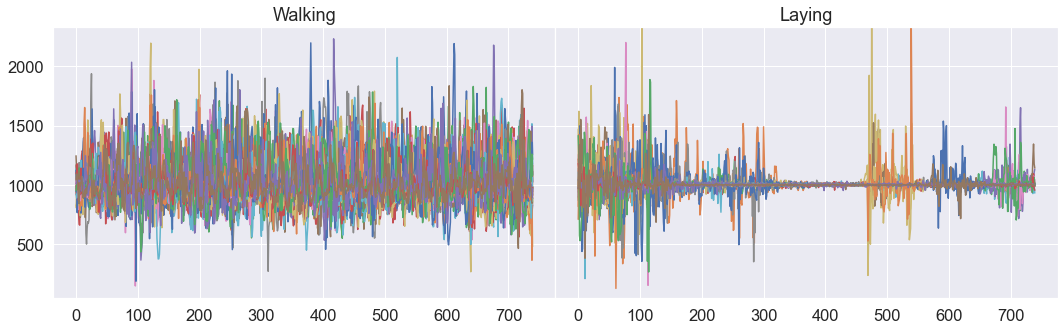

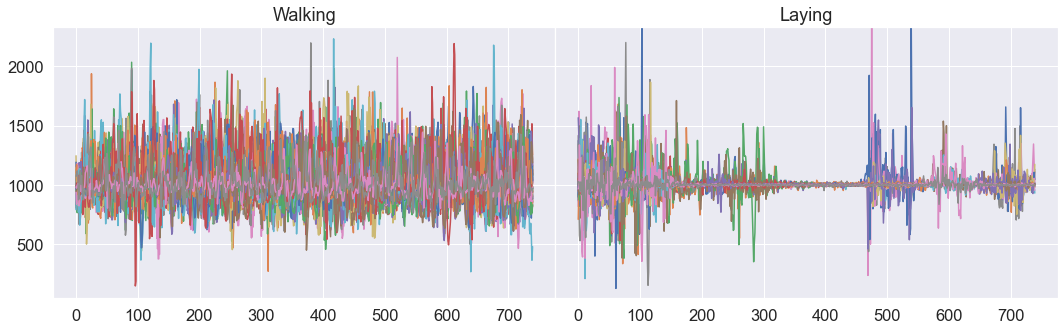

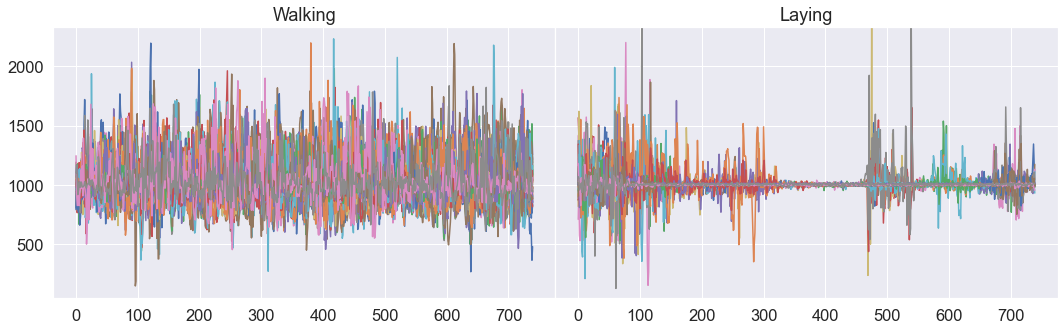

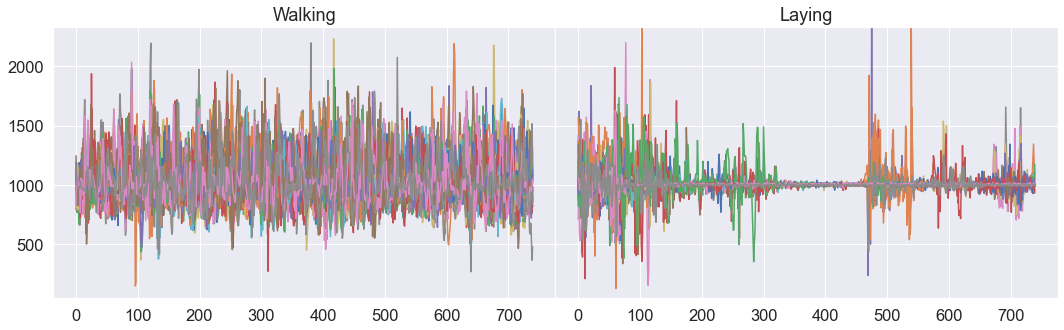

In [121]:
def metrics (model, X, y):

    X = np.array(X)
    X = X.reshape(X.shape[0], 1, X.shape[1])

    if not os.path.isdir('models'): 
        os.mkdir('models')

    learn = load_learner(model)
    dls = learn.dls
    valid_dl = dls.valid

    test_ds = valid_dl.dataset.add_test(X, y)
    test_dl = TSDataLoader(test_ds)

    test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl, with_decoded=True)
    from sklearn.metrics import accuracy_score, confusion_matrix
    acc = accuracy_score(y, test_preds)
    cmat = confusion_matrix(y, test_preds, normalize='true')
    return acc, cmat



sensors = ["triaxial_acc", "IMU_acc", "IMU_gyro"]
for c in range (1,5):
    for s in sensors:
        X, y = data_centers(sensors[1], c)
        acc, cmat = metrics('models/'+sensors[1]+'.pkl', X, y)
        print ('{} centers, sensor type {}\n'.format(c,s))
        print ('accuracy: ', acc, '\nconfusion matrix:\n', cmat)